# <div style="text-align: center;">**Dimensionality Reduction**</div>

# *Overview*

### **Scope**
The main objective of this project is to reduce the dimensionality of an image dataset and investigate the effectiveness of the different dimensionality-reduction models. To accomplish this, various dimensionality reduction algorithms were trained on a labeled training dataset consisting of digit images. Model performance was evaluated by measuring the test accuracy of transformed images using the K-Nearest Neighbors algorithm as the classifier. Following evaluations for different number of components, the optimal algorithm was chosen, and the advantages and disadvantages of alternative algorithms were evaluated.

### **About the Dataset**

The MNIST dataset is a widely used benchmark dataset in the field of machine learning and computer vision. It consists of a collection of 28x28 pixel grayscale images of handwritten digits (0 through 9). Each image is labeled with the corresponding digit it represents. MNIST stands for "Modified National Institute of Standards and Technology," referring to the original dataset created from a subset of NIST's Special Database 3 and Special Database 1.

The dataset is often employed to explore various techniques, such as dimensionality reduction, feature engineering, and different neural network architectures. Researchers use it to demonstrate and compare the effectiveness of different methodologies.

It's important to note that while MNIST has been a foundational dataset, more challenging datasets and tasks have emerged over time, encouraging the development of more sophisticated models and algorithms. However, MNIST remains a classic and valuable resource in the machine learning community.

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples.
Four files are available:

- train-images-idx3-ubyte.gz: training set images (9912422 bytes)
- train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
- t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
- t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

### Libraries used

In [108]:
import pandas as pd

import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import sklearn objects
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import MDS, Isomap
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

# Data Collection helper libraries
from sklearn import datasets

# Import plotting libraries
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Ignore the following Warnings:

In [109]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# *Data Collection & EDA*

In [110]:
numbers = datasets.load_digits()
numbers

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

# *Data Preprocessing*

Lets split the dataset into training and testing

In [111]:
X, y = numbers.data, numbers.target
print('The dimension of X is: {}'.format(X.shape))
print('The number of unique digits is: {}'.format(len(np.unique(y))))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # lets use random_state=0 for repeatable results
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

The dimension of X is: (1797, 64)
The number of unique digits is: 10
Train set: (1437, 64) (1437,)
Test set: (360, 64) (360,)


The dimension fo X is (1797, 64). We therefore have 1797 samples, each consisting of 64 components.

Lets visualize a sample of our train dataset to see what the digits look like

In [112]:
def plot_digits(X, title, reduced=False, fig_show=True):
    if reduced==False: # plot 100 digits 
        fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    else: # plot 25 digits if reduced is set to True
        fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((8, 8)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)
    
    if fig_show==True:
        plt.show()
    else:
        return fig

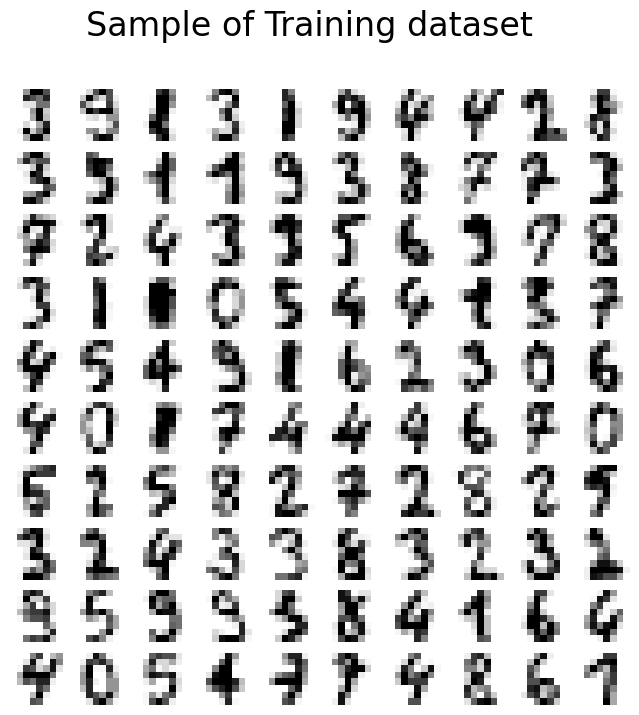

In [113]:
plot_digits(X_train, "Sample of Training dataset")

# *Modelling*

In this section, we explore the various approaches to dimensionality reduction and then compare the results using a clustering algorithm. Lets begin our analysis by considering a dimensionality reduction to 2 dimensions.

In [114]:
n_components = 2

Initialize dataframe with testing scores

In [115]:
scores_df = pd.DataFrame()
scores_df.sort_index()

Plotting helper function

In [117]:
def plot_results(model, model_name, fig_show=True):
    n_neighbors=3
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train,y_train)
    knn.fit(model.transform(X_train),y_train)
    acc_knn = knn.score(model.transform(X_test), y_test)
    scores_df.loc[n_components, model_name] = acc_knn
    X_embedded = model.transform(X)
    df = pd.DataFrame(np.concatenate((X_embedded, np.reshape(y, (-1, 1))), axis=1))
    
    if n_components>=4:
        # impractical visualizing 4D plot
        return
    elif n_components==3: # make a 3D plot for 3 dimensions
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, s=20, cmap='Set1')
    else: # make a 2D plot for 2 dimensions
        fig, ax = plt.subplots(figsize=(10, 8))  
        scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=20, cmap='Set1')
        for i, number in enumerate(y_test):
            ax.annotate(number, # label the clusters
                        df.loc[df[2] == number, [0, 1]].mean(),
                        horizontalalignment='center',
                        verticalalignment='center',
                        weight='bold',
                        size='14')
    ax.set_title("{}, Components={}, KNN_k={})\nTest accuracy = {:.2f}".format(model_name, n_components,
                                                                                  n_neighbors,
                                                                                  acc_knn))
    plt.colorbar(scatter)

    if fig_show==True:
        plt.show()
    else:
        return fig

## Principal Component Analysis

Principal Component Analysis or `PCA` is a dimensionality reduction technique commonly used in machine learning. Its primary goal is to transform high-dimensional data into a new coordinate system with a lower dimension. The new axes of this vector space are defined by considering the variance of the data in the original basis. More specifically, the algorithm finds directions in which variance is maximized and uses these direction to define the new basis for the space. This process allows for the reduction of the dimensionality of the data while retaining as much of the original variance as possible.

It is generally recommended to scale the data before applying `PCA`. Scaling ensures that all features have the same scale, which is important for `PCA` because it is based on the covariance matrix of the features. If features have different scales, those with larger scales may dominate the variance calculations, potentially leading to biased results.

In [119]:
n_components=2

In [120]:
# Lets define our pipeline
pipe_PCA = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(random_state=0, n_components=n_components))
])

In [121]:
# Hyperparameter grid
param_grid = {
    'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized']
}

In [122]:
GR = GridSearchCV(pipe_PCA, param_grid=param_grid, cv=5, scoring='f1')
GR.fit(X_train, y_train)
print("Best Parameters:", GR.best_params_)

Best Parameters: {'pca__svd_solver': 'auto'}


In [123]:
pipe_PCA = make_pipeline(
    StandardScaler(),
   PCA(random_state=0, n_components=n_components, svd_solver=GR.best_params_['pca__svd_solver'])
)

Lets visualize the results of the algorithm

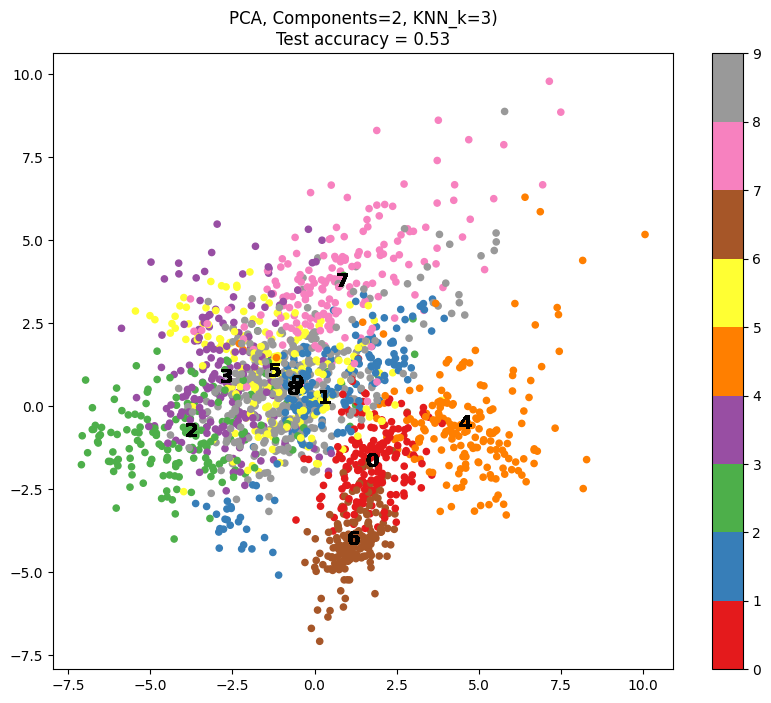

In [124]:
plot_results(pipe_PCA, 'PCA')

Lets plot a sample of the transformed test digits

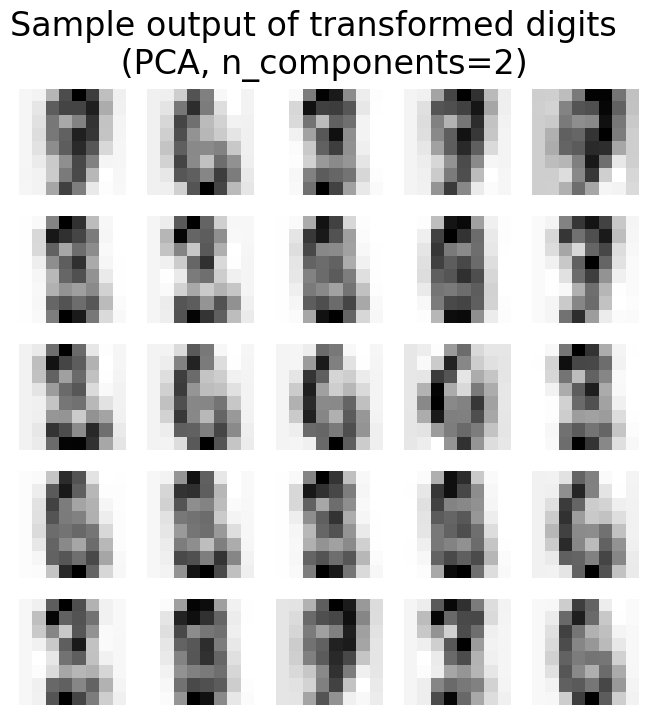

In [125]:
X_transformed = pipe_PCA.inverse_transform(pipe_PCA.transform(X_test))
plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('PCA', n_components), reduced=True)

## Kernel PCA

`KernelPCA` is an extension of `PCA` that incorporates the use of kernel functions to handle non-linear relationships within the data. While traditional `PCA` relies on linear transformations to capture the maximum variance in the original feature space, `KernelPCA` enables the exploration of non-linear structures by implicitly mapping the data into a higher-dimensional space using a chosen kernel. The key difference lies in the ability of `KernelPCA` to capture complex, non-linear patterns that `PCA` may struggle with. This becomes particularly advantageous when dealing with datasets that exhibit non-linear relationships or are characterized by intricate structures. Examples include image recognition, genetics, and natural language processing. However, it's essential to note that `KernelPCA` may be computationally more demanding than `PCA`, and the choice of an appropriate kernel and its parameters becomes crucial for achieving optimal results.

In [126]:
# Lets define our pipeline
pipe_KPCA = Pipeline([
    ('ss', StandardScaler()),
    ('kpca', KernelPCA(random_state=0, n_components=n_components))
])

In [127]:
# Hyperparameter grid
param_grid = {
    'kpca__kernel': ['poly', 'rbf', 'sigmoid', 'cosine'] # we can also use a 'linear' kenrel, but that would give the same results as PCA
}

In [128]:
GR = GridSearchCV(pipe_KPCA, param_grid=param_grid, cv=5, scoring='f1')
GR.fit(X_train, y_train)
print("Best Parameters:", GR.best_params_)

Best Parameters: {'kpca__kernel': 'poly'}


In [129]:
pipe_KPCA = make_pipeline(
    StandardScaler(),
    KernelPCA(random_state=0, n_components=n_components, kernel='rbf', fit_inverse_transform=True)
)
# Notice: unlike PCA in KernelPCA, you need to set fit_inverse_transform=True to be able to get your original data

Lets visualize the results of the algorithm

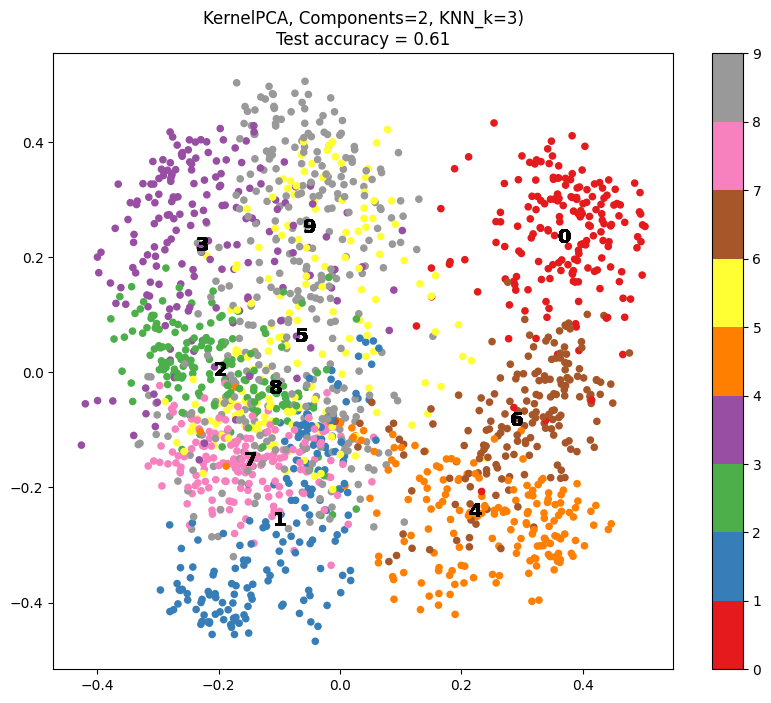

In [130]:
plot_results(pipe_KPCA, 'KernelPCA')

Lets plot a sample of the transformed test digits

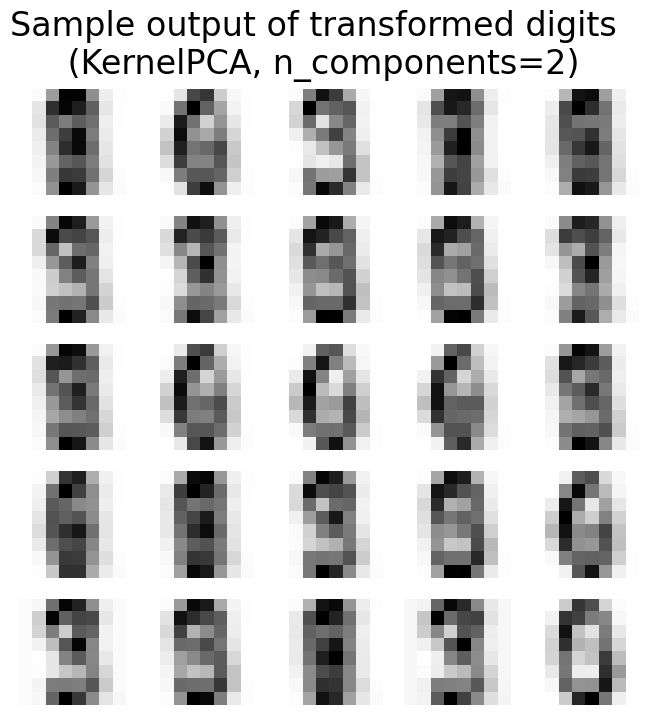

In [131]:
X_transformed = pipe_KPCA.inverse_transform(pipe_KPCA.transform(X_test))
plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('KernelPCA', n_components), reduced=True)

## Multi-Dimensional Scaling

Multi-Dimensional Scaling or `MSD` is a dimensionality reduction technique used in data analysis and visualization to represent high-dimensional data in a lower-dimensional space while preserving the pairwise distances between data points. The fundamental idea behind MDS is to capture the essential geometric relationships among data points by projecting them into a lower-dimensional space (rather than preserving variance like PCA).

In [132]:
pipe_MDS = make_pipeline(
    StandardScaler(),
    MDS(random_state=0, n_components=n_components)
)
pipe_MDS.fit_transform(X_train)

array([[-1.86344788,  2.28138228],
       [-6.33050214, -2.89401687],
       [ 4.90372562,  1.52524297],
       ...,
       [ 1.52031461, -5.62226111],
       [-0.99097225, 10.54454186],
       [ 0.7583114 , -0.28281039]])

Unforunately, sklearn MDS, SpectralEnbedding, and TSNE cannot be used for feature reduction for classification. They do not have a stand-alone transform() method like KernelPCA or LocallyLinearEmbedding. Without a transform() method, there is no way to transform and score new data. They also don't have a inverse_transform() function, so we can not see the dimensionaly-reduced digits.

## Isomap

Isomap is a dimensionality reduction technique designed to capture the intrinsic geometry of complex, nonlinear manifolds in high-dimensional data. By preserving geodesic distances through neighborhood information, Isomap is particularly useful in scenarios where the underlying structure of the data is best represented by a nonlinear manifold, such as in the analysis of sensory data, facial recognition, or any dataset with intricate nonlinear relationships.

In [133]:
# Lets define our pipeline
pipe_Isomap = make_pipeline(
    StandardScaler(),
    Isomap(n_components=n_components, n_jobs=-1, n_neighbors=3)
)

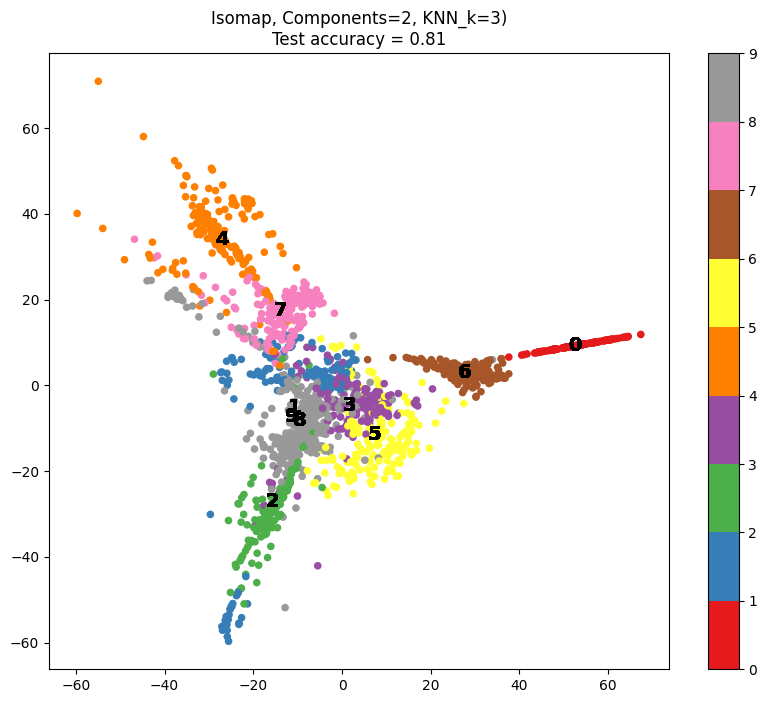

In [134]:
plot_results(pipe_Isomap, 'Isomap')

Unfortunately, Isomap object has no attribute 'inverse_transform', so we cannot see the reduced digits.

## Non-Negative Matrix Factorization

Non-Negative Matrix Factorization or `NMF` is a dimensionality reduction and matrix factorization technique that is particularly useful for datasets where all the values are non-negative. The method factorizes a given non-negative data matrix into the product of two lower-dimensional matrices, where all elements in the matrices are constrained to be non-negative. Mathematically, if you have a non-negative data matrix V of size (m x n), NMF decomposes it into two matrices $W$ (m x r) and $H$ (r x n), where r is the reduced dimensionality.

The goal of NMF is to find the two factor matrices W and H such that their product approximates the original matrix V:

$V≈WH$

Here, W contains the basis vectors for the reduced representation, and H contains the coefficients that express the original data in terms of these basis vectors. The non-negativity constraint often leads to more interpretable parts-based representations.

Since all matrices are possitive, reconstruction of the original matrix is more intuitive since we just add the smaller components of the matrix. Notice that because `NMF` has this extra constraint of positive values, it will tend to loose more information when truncating.

In [135]:
pipe_NMF = make_pipeline(
    MinMaxScaler(), # We have to use min-max scaler here. Using StandardScaler terminates the operation (We can't have negative values in any of the matrices)
    NMF(random_state=0, n_components=n_components)
)

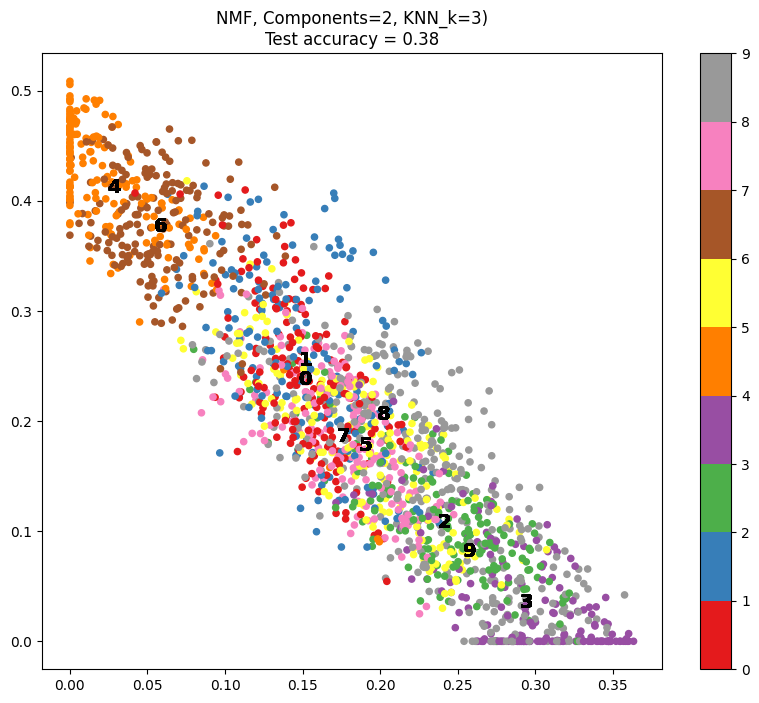

In [136]:
plot_results(pipe_NMF, 'NMF')

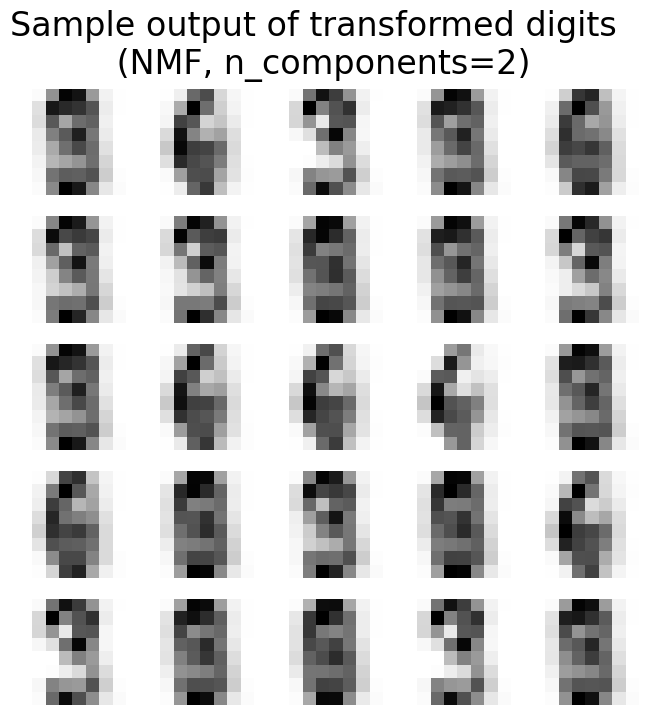

In [137]:
X_transformed = pipe_NMF.inverse_transform(pipe_NMF.transform(X_test))
plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('NMF', n_components), reduced=True)

## Singular Value Decomposition

Singular Value Decomposition (SVD) is a linear algebra technique that decomposes a matrix into three other matrices, providing a compact representation of the original matrix. For a given $m$ x $n$ matrix $A$, SVD factorizes it accordingly:
$$A = UΣV^T$$
Where $U$ and $V$ are orthogonal matrices
$Σ$ is a diagonal non-negative matrix

The SVD provides a way to factorize a matrix into components that capture its underlying structure. It is widely used in various applications, including dimensionality reduction, noise reduction, and solving linear systems. The singular values in $Σ$ indicate the importance of each mode of variation in the data, and the corresponding columns in $U$ and $V$ provide the basis vectors for these modes. SVD is a fundamental tool in numerical linear algebra with applications in diverse fields.

In [138]:
pipe_SVD = make_pipeline(
    StandardScaler(),
    TruncatedSVD(random_state=0, n_components=n_components)
)

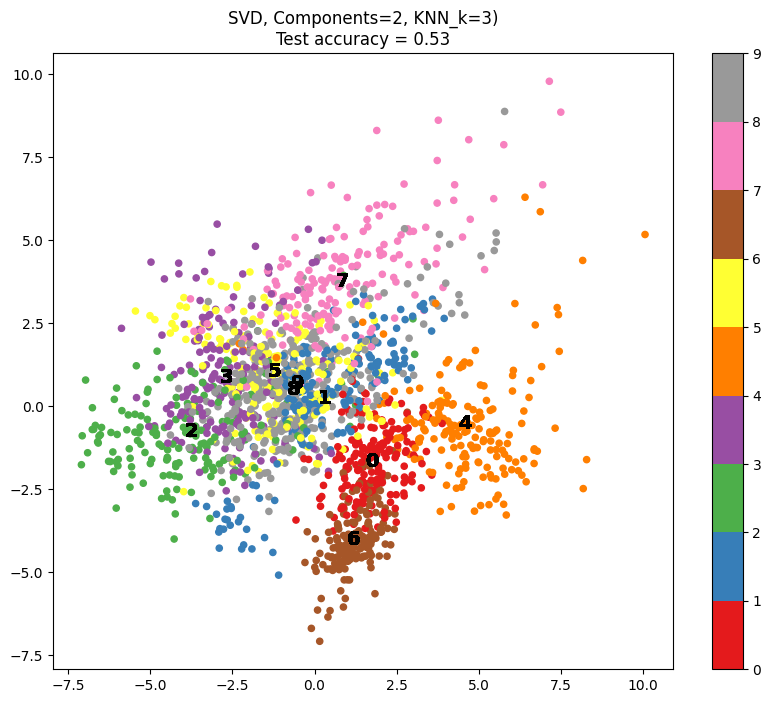

In [139]:
plot_results(pipe_SVD, 'SVD')

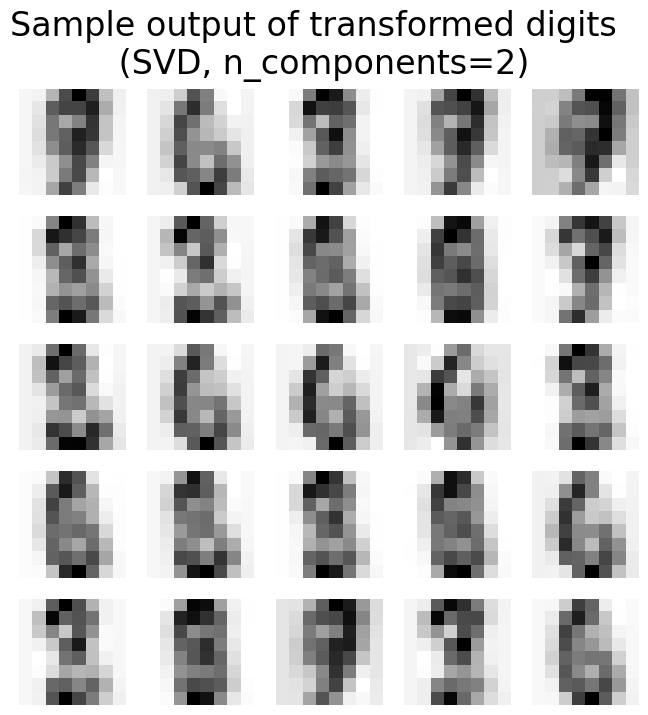

In [140]:
X_transformed = pipe_SVD.inverse_transform(pipe_SVD.transform(X_test))
plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('SVD', n_components), reduced=True)

In [141]:
scores_df

,PCA,KernelPCA,Isomap,NMF,SVD
2,0.530556,0.613889,0.813889,0.375,0.530556


### Early observations

We can already see the importance of changing the basis and performing linear transformations on our original features. By using only 2 features (out of 64!), almost all the algorithms have captured more than 50% of the variance in the digits. This method proves very advantageous when working with a dataset that has a large volume of features. The excess of features can slow down the modeling phase, as they usually contain redundant information or exhibit multicollinearity.

# *Model Evaluation*

## Evaluating Scores up to 6 principal components

Best Parameters: {'pca__svd_solver': 'auto'}


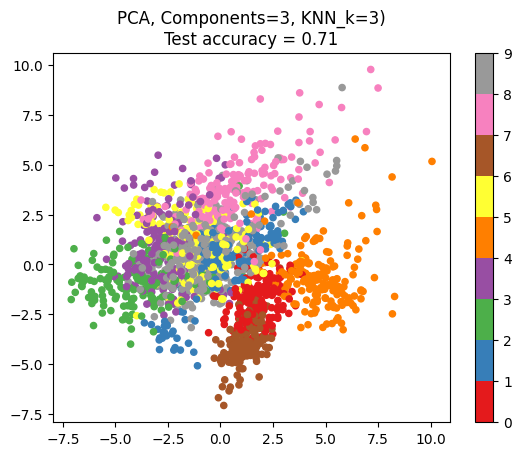

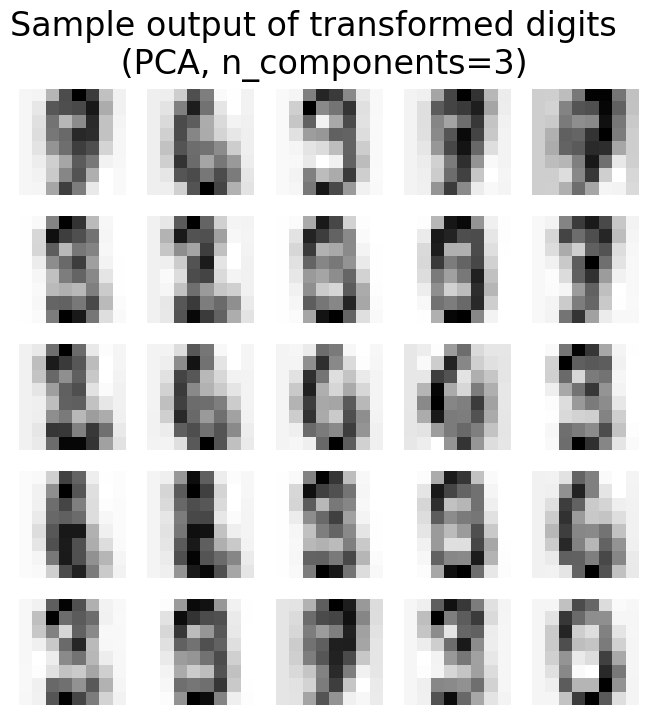

Best Parameters: {'kpca__kernel': 'poly'}


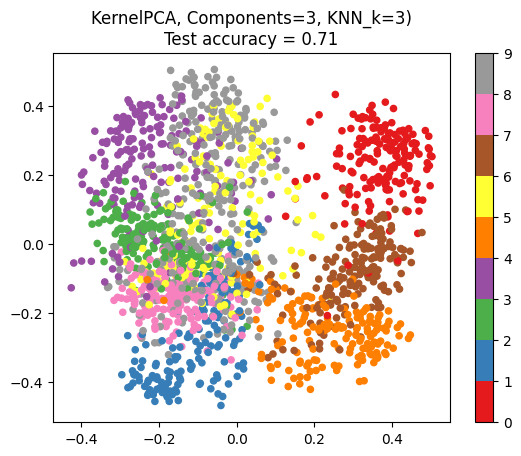

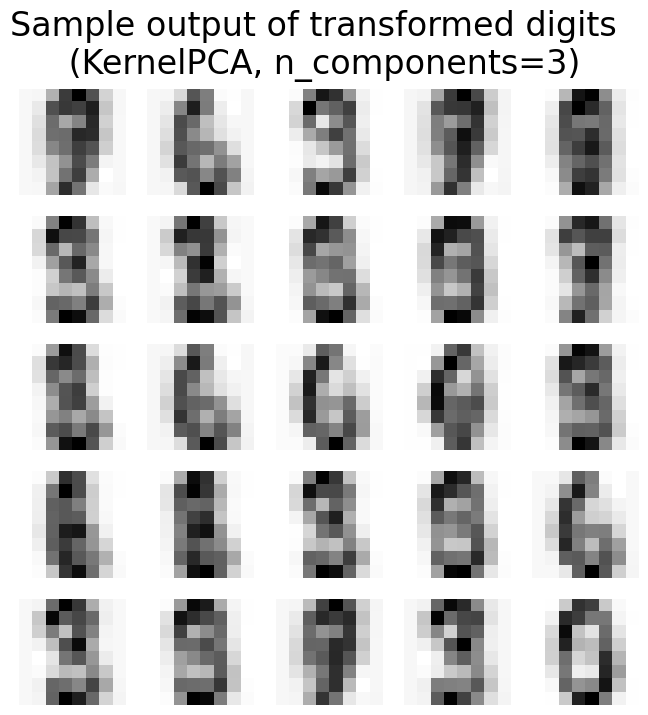

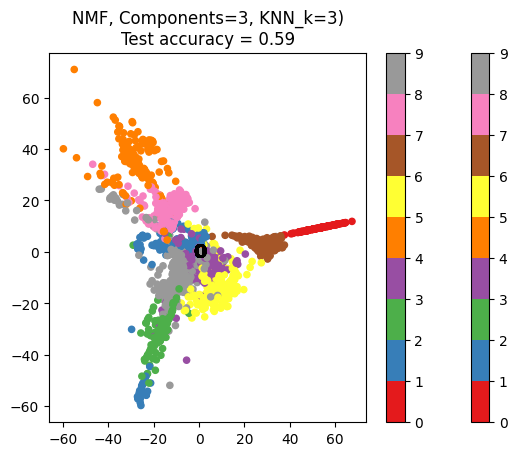

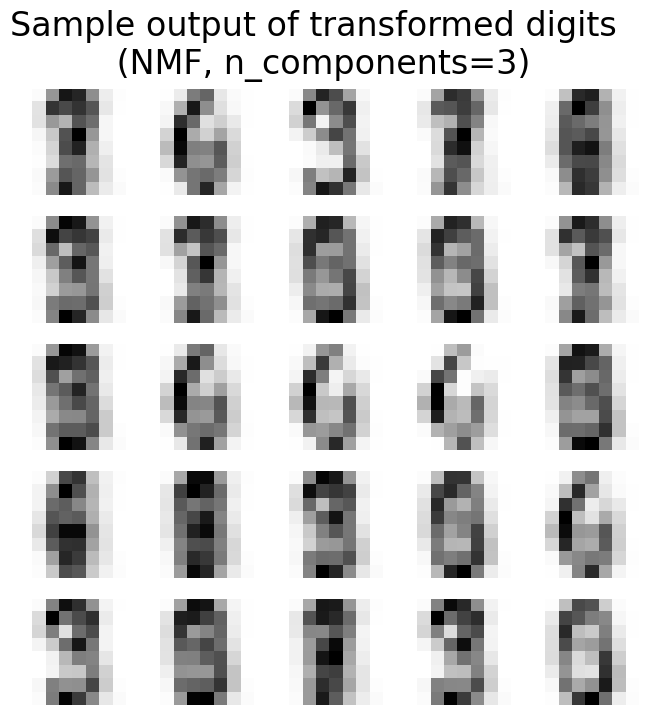

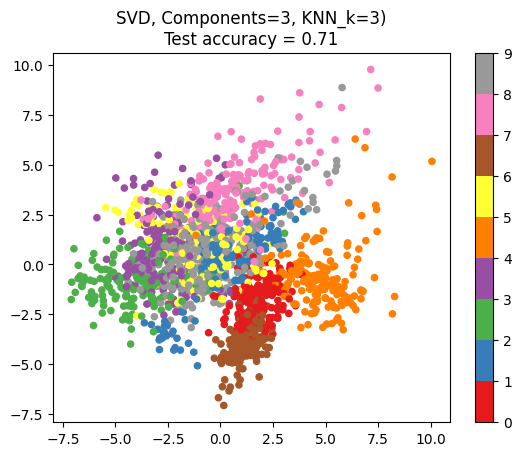

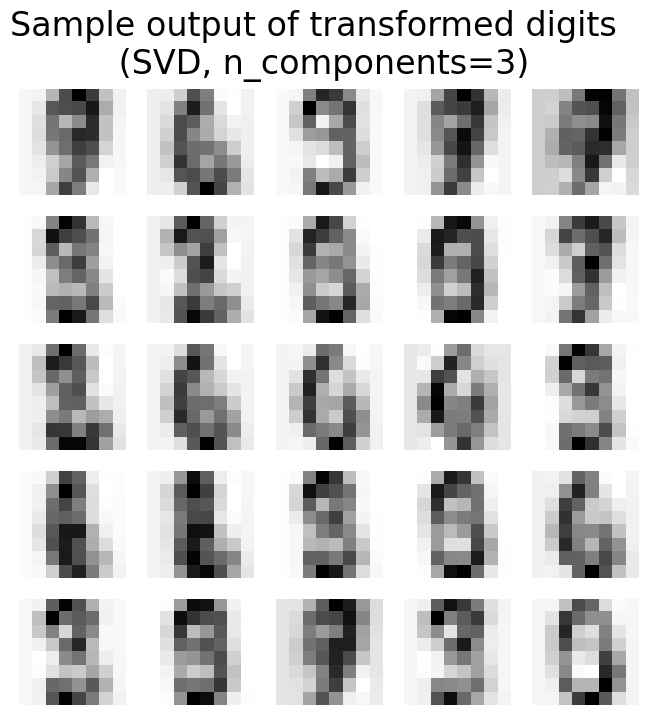

Best Parameters: {'pca__svd_solver': 'auto'}


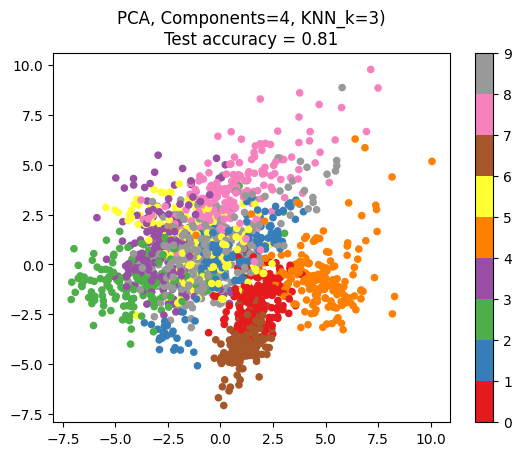

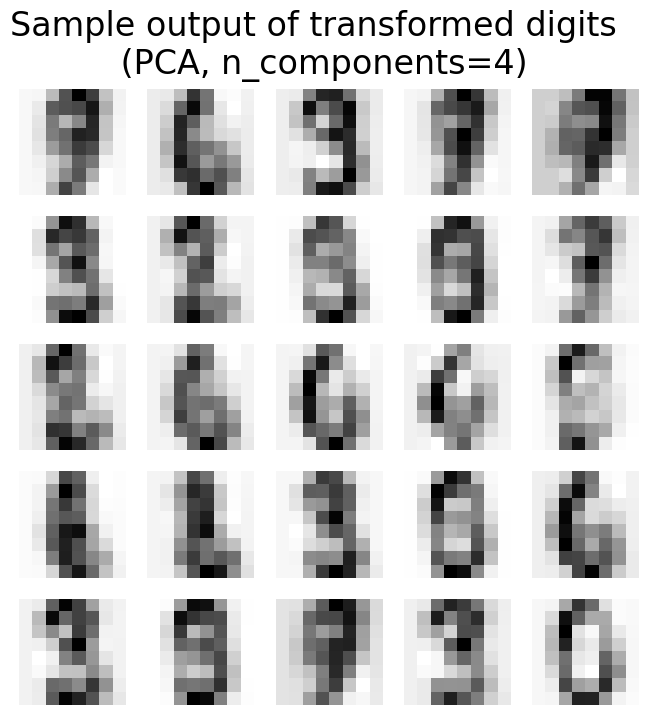

Best Parameters: {'kpca__kernel': 'poly'}


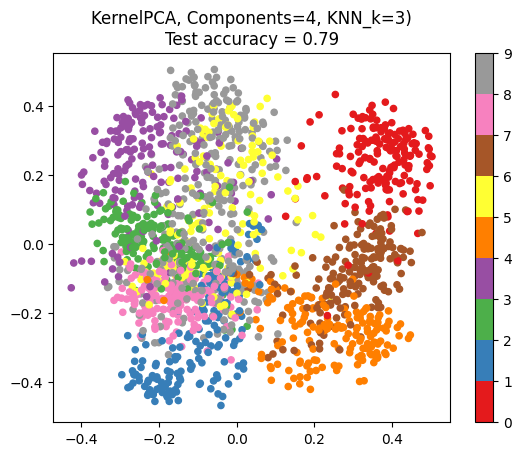

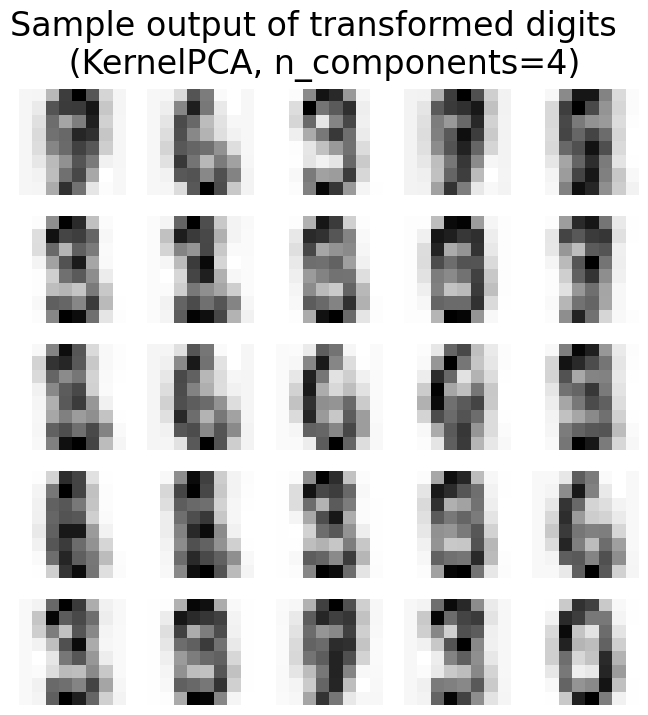

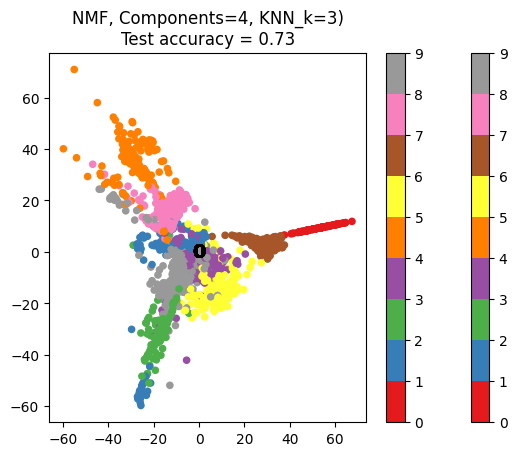

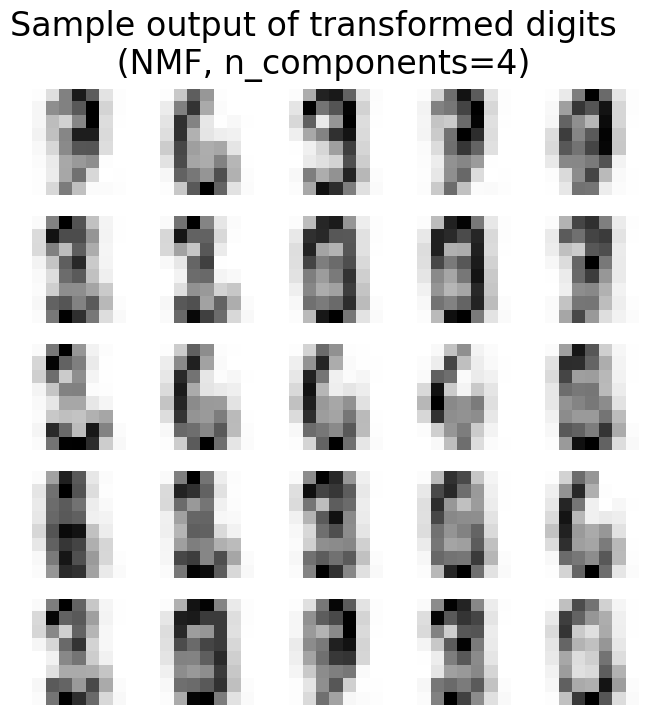

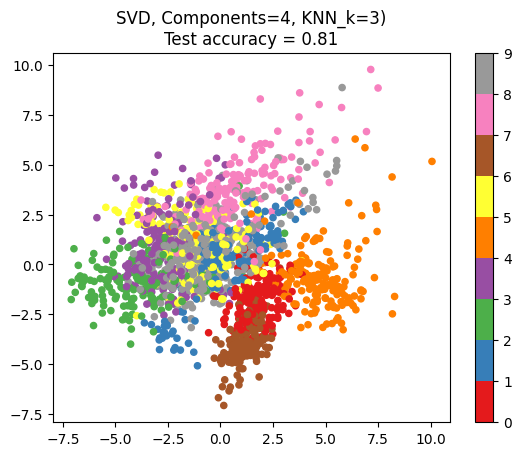

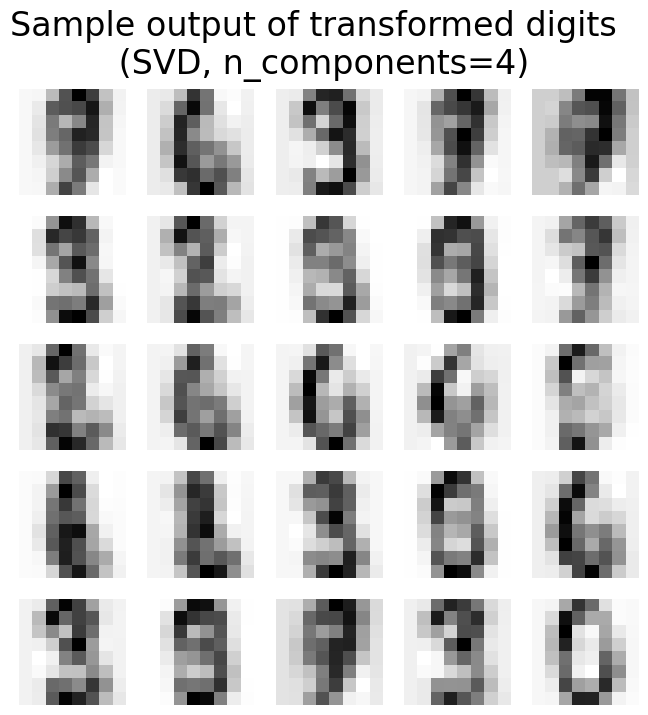

Best Parameters: {'pca__svd_solver': 'auto'}


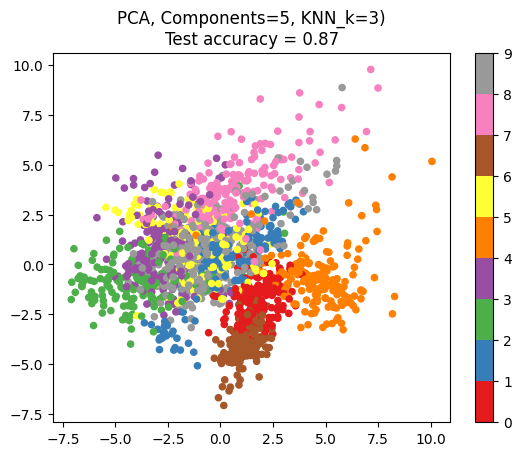

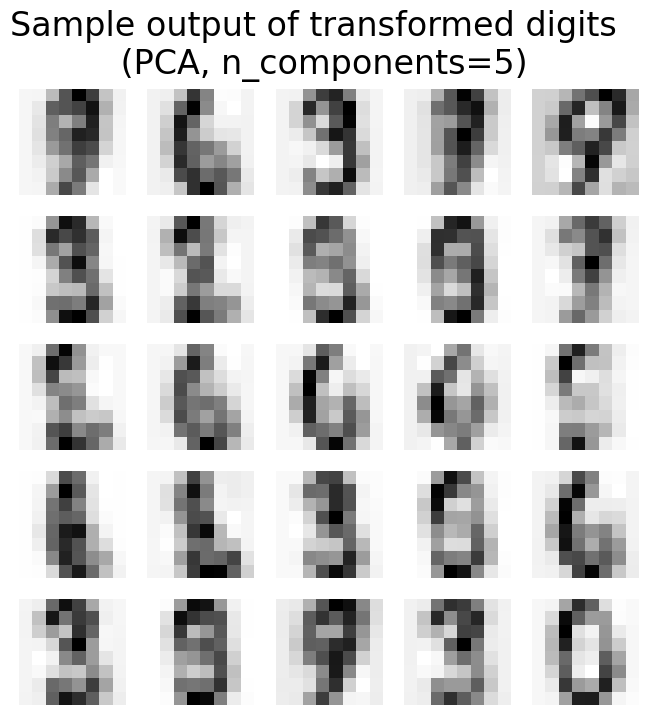

Best Parameters: {'kpca__kernel': 'poly'}


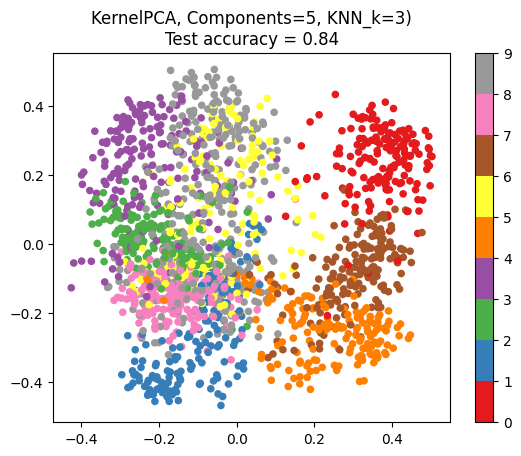

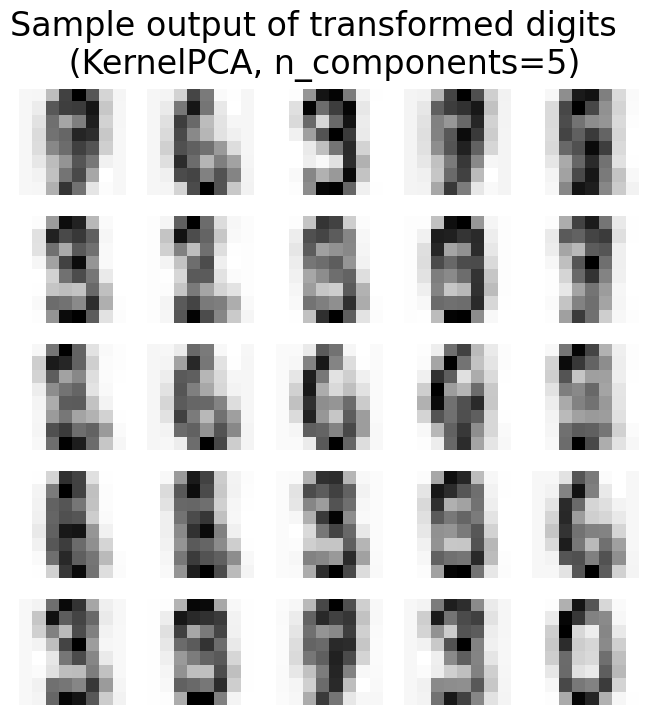

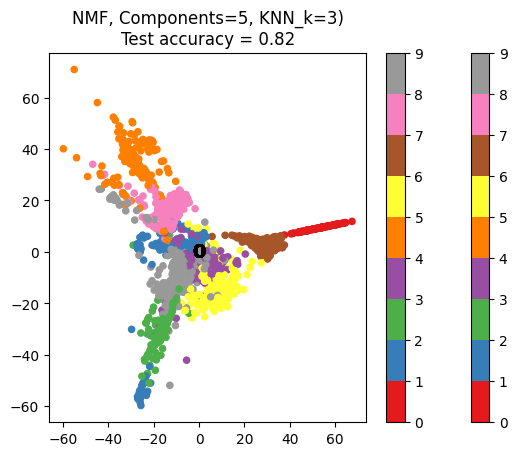

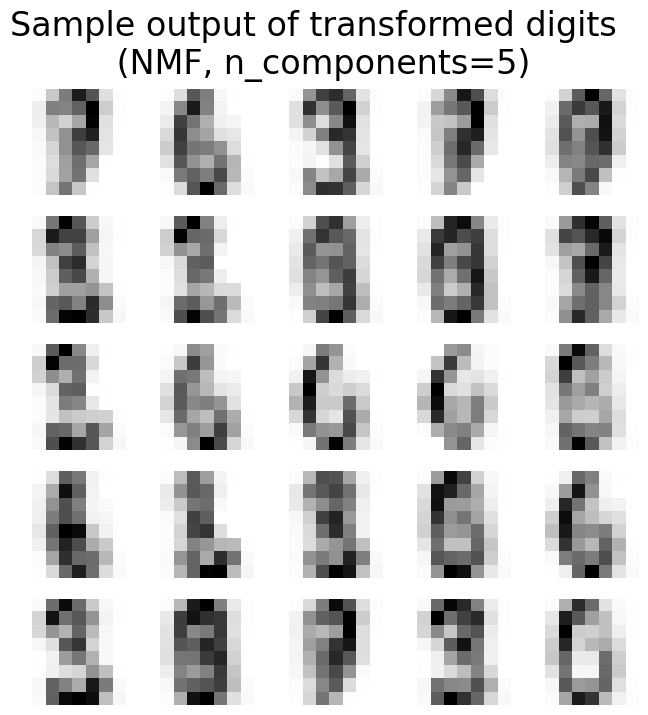

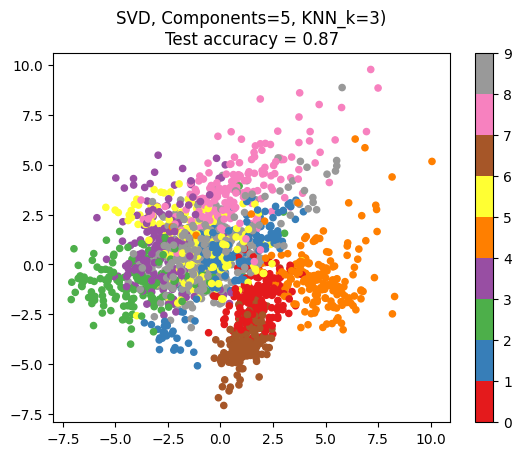

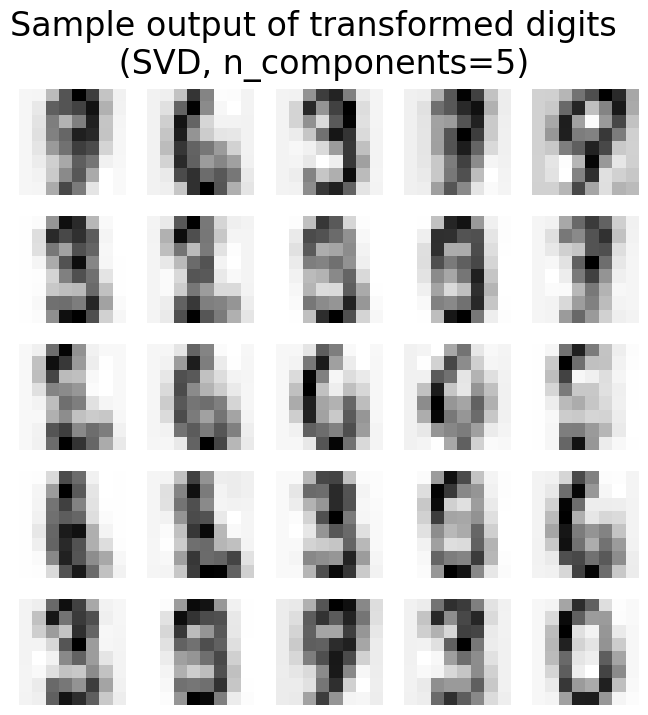

Best Parameters: {'pca__svd_solver': 'auto'}


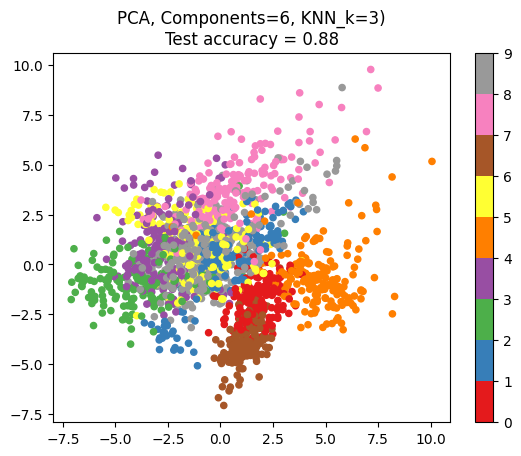

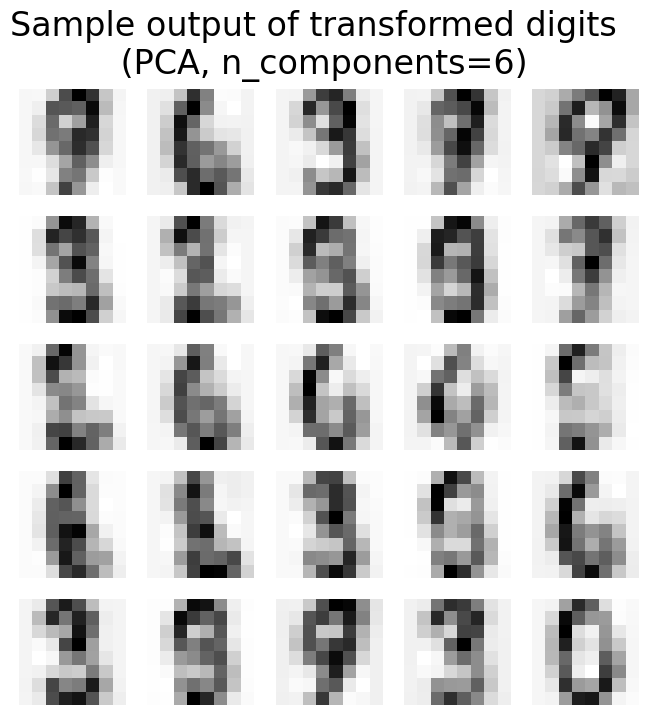

Best Parameters: {'kpca__kernel': 'poly'}


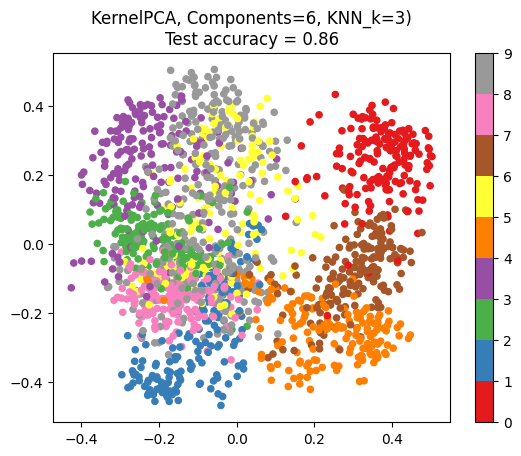

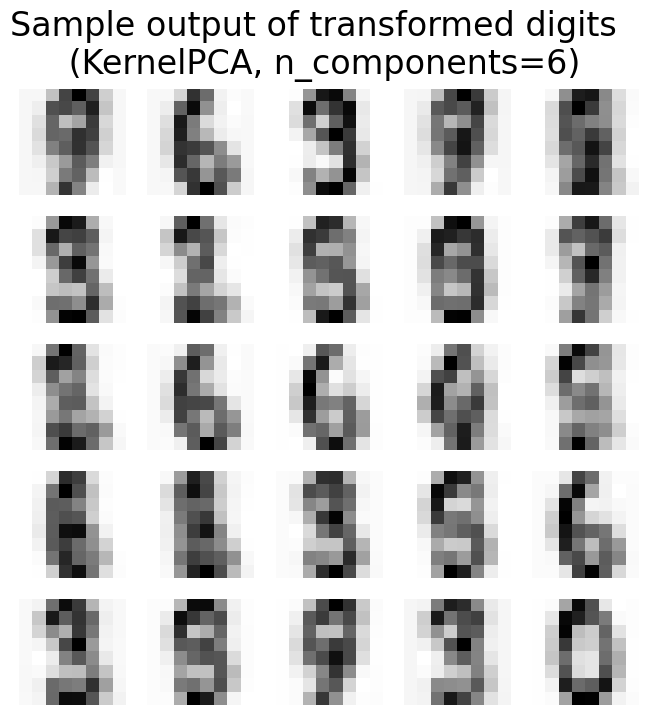

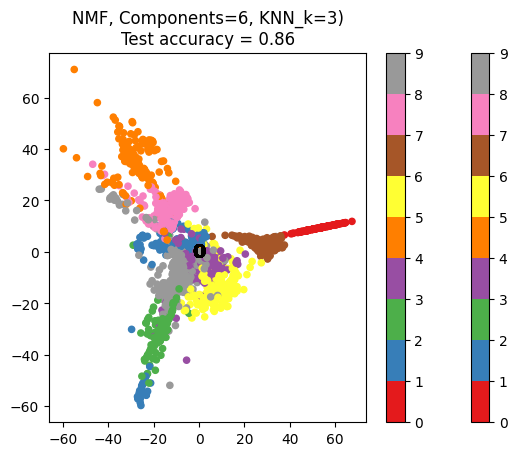

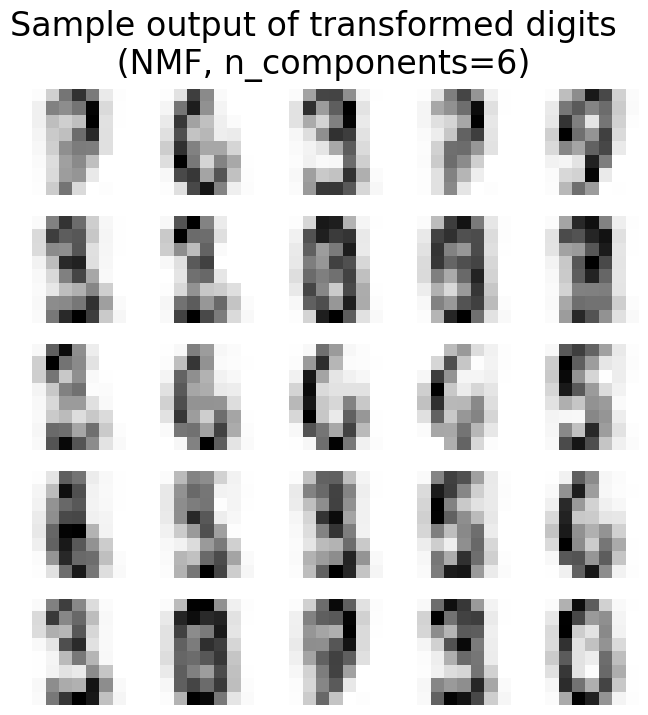

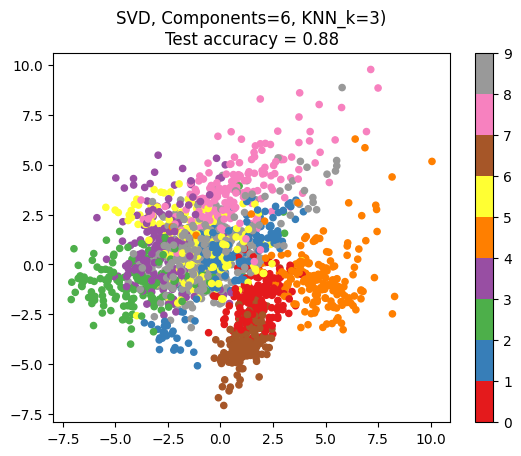

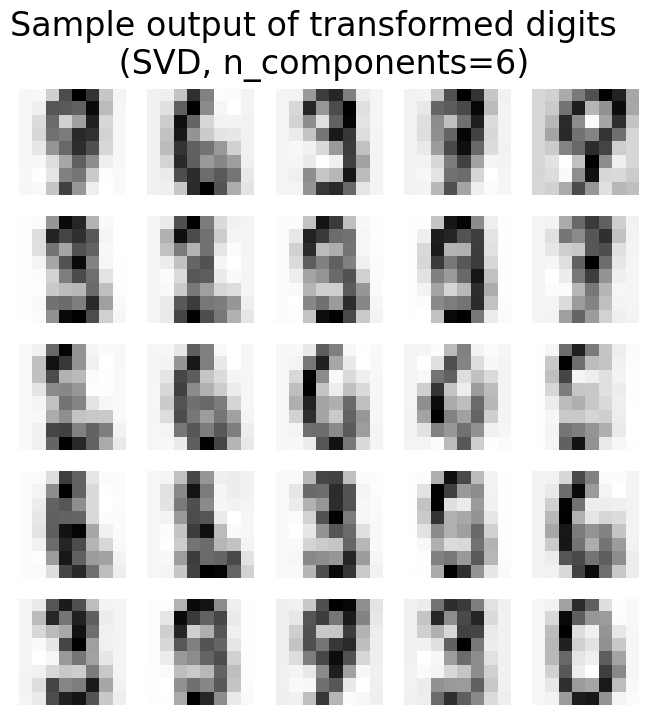

In [159]:
for n_components in range(3, 7, 1):

# PCA
    pipe_PCA = Pipeline([
        ('ss', StandardScaler()),
        ('pca', PCA(random_state=0, n_components=n_components))
    ])
    param_grid = {
        'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized']
    }
    GR = GridSearchCV(pipe_PCA, param_grid=param_grid, cv=5, scoring='f1')
    GR.fit(X_train, y_train)
    print("Best Parameters:", GR.best_params_)
    pipe_PCA = make_pipeline(
        StandardScaler(),
        PCA(random_state=0, n_components=n_components, svd_solver=GR.best_params_['pca__svd_solver'])
    )
    plot_results(pipe_PCA, 'PCA')
    X_transformed = pipe_PCA.inverse_transform(pipe_PCA.transform(X_test))
    plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('PCA', n_components), reduced=True)

# KernelPCA
    pipe_KPCA = Pipeline([
        ('ss', StandardScaler()),
        ('kpca', KernelPCA(random_state=0, n_components=n_components))
    ])
    param_grid = {
        'kpca__kernel': ['poly', 'rbf', 'sigmoid', 'cosine']
    }
    GR = GridSearchCV(pipe_KPCA, param_grid=param_grid, cv=5, scoring='f1')
    GR.fit(X_train, y_train)
    print("Best Parameters:", GR.best_params_)
    pipe_KPCA = make_pipeline(
        StandardScaler(),
        KernelPCA(random_state=0, n_components=n_components, kernel='rbf', fit_inverse_transform=True)
    )
    plot_results(pipe_KPCA, 'KernelPCA')
    X_transformed = pipe_KPCA.inverse_transform(pipe_KPCA.transform(X_test))
    plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('KernelPCA', n_components), reduced=True)

# Isomap
    pipe_Isomap = make_pipeline(
        StandardScaler(),
        Isomap(n_components=n_components, n_jobs=-1, n_neighbors=3)
    )
    fig = plot_results(pipe_Isomap, 'Isomap') 
    pipe_NMF = make_pipeline(
        MinMaxScaler(), 
        NMF(random_state=0, n_components=n_components)
    )
    plot_results(pipe_NMF, 'NMF')
    X_transformed = pipe_NMF.inverse_transform(pipe_NMF.transform(X_test))
    plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('NMF', n_components), reduced=True)

# SVD
    pipe_SVD = make_pipeline(
        StandardScaler(),
        TruncatedSVD(random_state=0, n_components=n_components)
    )
    plot_results(pipe_SVD, 'SVD')
    X_transformed = pipe_SVD.inverse_transform(pipe_SVD.transform(X_test))
    plot_digits(X_transformed, "Sample output of transformed digits \n ({}, n_components={})".format('SVD', n_components), reduced=True)

In [149]:
scores_df

,PCA,KernelPCA,Isomap,NMF,SVD
2,0.530556,0.613889,0.813889,0.375000,0.530556
3,0.713889,0.713889,0.927778,0.588889,0.713889
4,0.808333,0.794444,0.952778,0.727778,0.808333
5,0.869444,0.841667,0.947222,0.816667,0.869444
6,0.880556,0.863889,0.955556,0.855556,0.877778


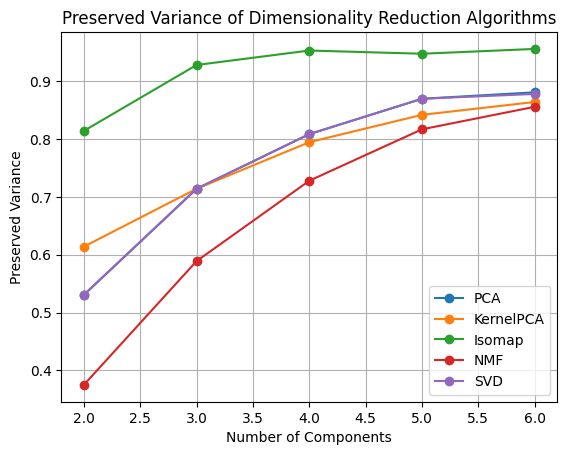

In [157]:
scores_df.plot(kind='line', style='o-')
plt.xlabel('Number of Components')
plt.ylabel('Preserved Variance')
plt.title('Preserved Variance of Dimensionality Reduction Algorithms')
plt.grid()
plt.show()

# *Discussion*

We observe a gradual convergence of the curves as the number of dimensions increases. It's essential to note that, given the use of test data to estimate preserved variance, the curves will never precisely converge to 1. However, they should approach the lower limit as components increases, reaching a stable pattern when $components \rightarrow 64$.

We also notice similarities in the metrics of the PCA and SVM algorithms across all principal components. This suggests a common preprocessing or feature extraction step between the two algorithms. The shared metrics likely result from applying PCA for dimensionality reduction as a preprocessing step before performing feature extraction by feeding the processed data into the SVM.

Based on the obtained results, the `Isomap` algorithm clearly stands out as the superior model. I would therefore use this algorithm with the parameter `n_components = 3` to reduce the dimension of the digit pictures. In the scenario where obtaining reduced digit pictures is required, and considering that Isomap lacks an `inverse_transform` function, I would utilize `PCA` with n_components=5. Having the `inverse_transform` function for transformed digit pictures is crucial for facilitating a meaningful comparison between the original digits and their transformed counterparts. Without the `inverse_transform` capability, assessing the quality of the dimensionality reduction or transformation process would be challenging. The ability to compare the original digits side by side with their inverse-transformed versions enables a visual evaluation of how well the algorithm preserves the essential features of the data during the reduction process.

The `NMF` algorithm performed worse than the other dimensional reduction models. In cases where interpretability and transparency in feature extraction are crucial, NMF's intuitive nature becomes especially useful. This algorithm is particularly well-suited for scenarios where the goal is to uncover meaningful patterns or representations in the data, allowing practitioners to directly interpret the contributions of different components in the factorization process. Some applications include topic modeling, face recognition, and signal processing, where understanding the composition of the latent features is essential for making informed decisions or drawing meaningful conclusions from the reduced-dimensional representation.

# Author 

### [Panagiotis Stenos](https://www.linkedin.com/in/panstenos/)